In [144]:
import networkx as nx
import matplotlib.pyplot as plt
import time
import os
from itertools import product
import re
from copy import deepcopy
import random

In [145]:
def neighbor_edges_of_node(graph, node):
    neighbor_edges = []
    for edge in graph.edges():
        if node in edge:
            neighbor_edges.append(edge)
    return neighbor_edges

In [146]:
def is_valid_coloring(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    
    for edge in graph.edges():
        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                return False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                return False
    return True

In [147]:
def initialize(graph):
    return [random.randrange(1, len(graph.edges())) for _ in range(len(graph.edges()))]

In [148]:
#broj grana koje su tacno obojene
def calculate_value(graph, coloring):
    edge_color = {edge: coloring[i] for i, edge in enumerate(graph.edges())}
    num = 0

    for edge in graph.edges():
        indicator = True

        u, v = edge
        
        u_edges = neighbor_edges_of_node(graph, u)
        v_edges = neighbor_edges_of_node(graph, v)

        u_edges.remove(edge)
        v_edges.remove(edge)
        
        for i in range(len(u_edges)):
            if edge_color[u_edges[i]] == edge_color[edge]:
                indicator = False
        
        for j in range(len(v_edges)):  
            if edge_color[v_edges[j]] == edge_color[edge]:
                indicator = False

        if indicator:
            num += 1
    
    return len(graph.edges()) - num

In [149]:
def make_small_change_colors(solution):
    max_num = max(solution)
    second_max = max(num for num in solution if num != max_num)

    new_solution = [second_max if num == max_num else num for num in solution]
    return new_solution

In [150]:
def make_small_change_shuffle(graph, solution):
    # new_solution = deepcopy(solution)
    # random_idx = random.randrange(len(solution))
    # random_idx_two = random.randrange(len(solution))

    # tmp = new_solution[random_idx]
    # new_solution[random_idx] = new_solution[random_idx_two]
    # new_solution[random_idx_two] = tmp

    new_solution = deepcopy(solution)
    random_idx = random.randrange(len(solution))
    new_solution[random_idx] = random.randrange(1, len(graph.edges()))

    return new_solution

In [151]:
def simulated_annealing(graph, max_iter=1000, initial_temperature=100.0, cooling_rate=0.95):
    coloring_result = initialize(graph)
    value = calculate_value(graph, coloring_result)

    best_coloring = None
    best_value = float('inf')
    
    current_temperature = initial_temperature
    iter_found = 0

    for i in range(max_iter):
        
        if current_temperature < 0.1:
            break
        
        if is_valid_coloring(graph, coloring_result):
            # smanji broj boja
            new_coloring = make_small_change_colors(coloring_result)
            new_value = calculate_value(graph, new_coloring)
        else:
            #zameni neki random index
            new_coloring = make_small_change_shuffle(graph, coloring_result)
            new_value = calculate_value(graph, new_coloring)
            
        # if is_valid_coloring(graph, new_coloring):
        if new_value < value:
            coloring_result = deepcopy(new_coloring)
            value = new_value 
            if new_value < best_value:          
                if is_valid_coloring(graph, new_coloring):          
                    best_coloring = deepcopy(new_coloring)
                    best_value = new_value
                    iter_found = i
        else:
            delta = new_value - value
            if delta < 0 or random.random() < pow(2.71828, delta / current_temperature):
                coloring_result = deepcopy(new_coloring)
                value = new_value

        current_temperature *= cooling_rate

    return best_coloring, iter_found

In [152]:
def draw_colored_graph(graph, coloring):    
    nx.draw(graph, with_labels=True, edge_color=coloring)
    plt.show()

In [153]:
def read_graph_from_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
        num_nodes, num_edges = map(int, lines[0].split()[2:])  # extractiong num_nodes and num_edges
        edges = [tuple(map(int, line.split()[1:])) for line in lines[1:] if line.startswith('e')]
        graph = nx.Graph()
        graph.add_nodes_from(range(1, num_nodes + 1))
        graph.add_edges_from(edges)
        
        return graph

In [154]:
def numerical_sort(value):
    parts = re.split(r'(\d+)', value)
    parts[1] = int(parts[1]) if len(parts) > 1 else 0
    return parts

In [155]:
def run_tests(directory):
    files = os.listdir(directory)
    sorted_files = sorted(files, key=numerical_sort)

    for file in sorted_files:
        if file.endswith('.txt'):
            filepath = os.path.join(directory, file)
            print(f"Running test {file}...")
            start_time = time.time()
            graph = read_graph_from_file(filepath)
            coloring_result, iter = simulated_annealing(graph, max_iter=1000, initial_temperature=100.0, cooling_rate=0.95)
            end_time = time.time()
            
            if(coloring_result):
                print("Minimum edge coloring found.")
                print(coloring_result)
                print("Number of colors:", len(set(coloring_result))) 
                print("Number of iterations:", iter)         
                draw_colored_graph(graph, coloring_result)
                plt.close()
            else:
                print("No solution exists.")
                
            print("Time taken:", end_time - start_time, "seconds")
            print()

Running test graph_3_edges.txt...
No solution exists.
Time taken: 0.015824317932128906 seconds

Running test graph_5_edges.txt...
Minimum edge coloring found.
[2, 4, 3, 1, 2]
Number of colors: 4
Number of iterations: 2


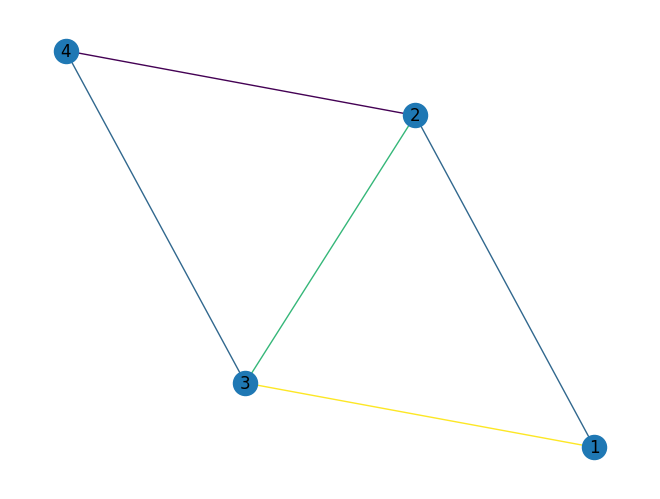

Time taken: 0.023192405700683594 seconds

Running test graph_5_edges_2.txt...
Minimum edge coloring found.
[3, 2, 4, 4, 1]
Number of colors: 4
Number of iterations: 15


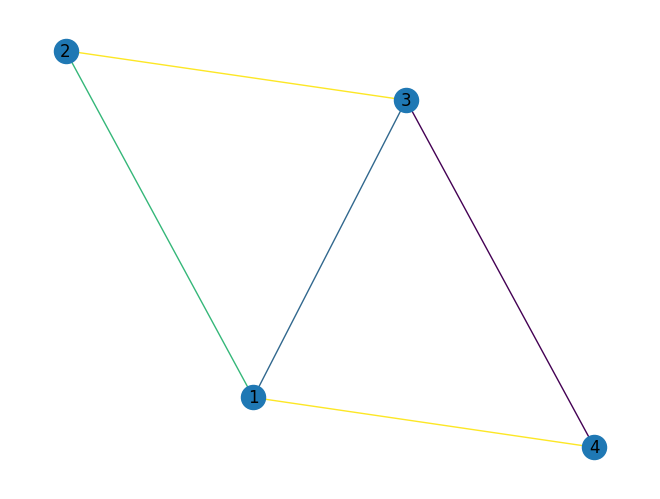

Time taken: 0.03993940353393555 seconds

Running test graph_6_edges.txt...
Minimum edge coloring found.
[1, 4, 5, 4, 1, 3]
Number of colors: 4
Number of iterations: 24


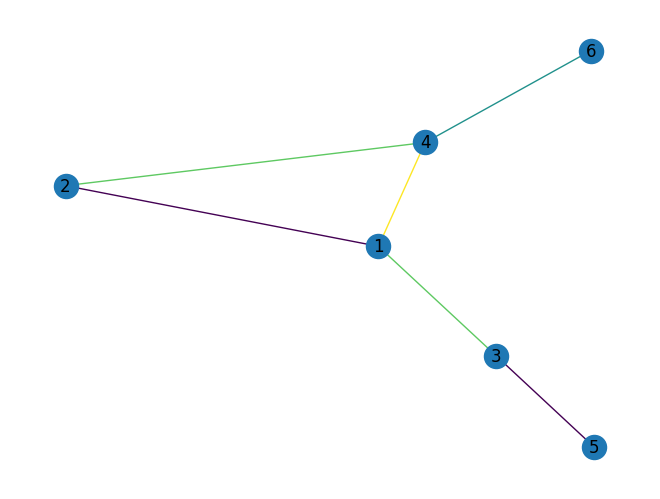

Time taken: 0.02485942840576172 seconds

Running test graph_7_edges.txt...
Minimum edge coloring found.
[6, 5, 2, 4, 1, 4, 6]
Number of colors: 5
Number of iterations: 38


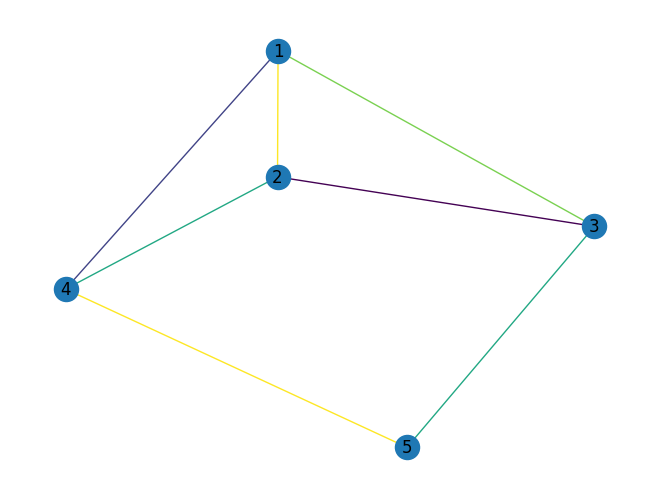

Time taken: 0.04819631576538086 seconds

Running test graph_7_edges_2.txt...
Minimum edge coloring found.
[1, 2, 5, 4, 6, 3, 4]
Number of colors: 6
Number of iterations: 3


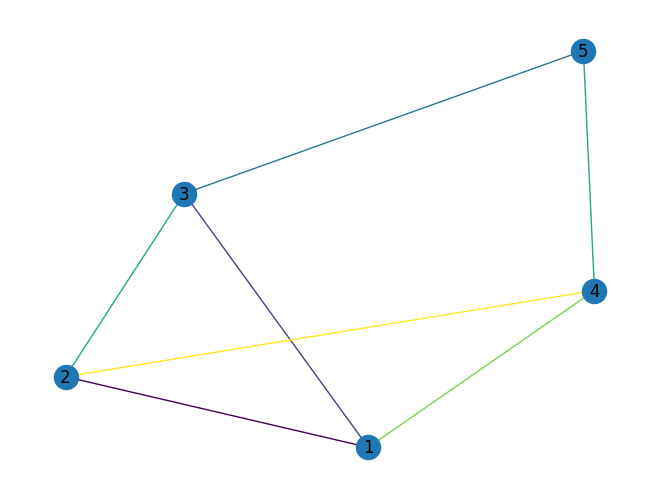

Time taken: 0.030208110809326172 seconds

Running test graph_7_edges_3.txt...
Minimum edge coloring found.
[6, 2, 5, 1, 1, 3, 4]
Number of colors: 6
Number of iterations: 6


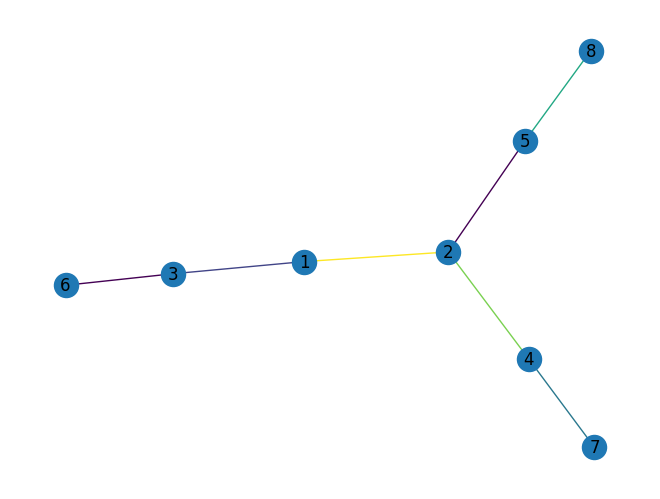

Time taken: 0.047834157943725586 seconds

Running test graph_8_edges.txt...
Minimum edge coloring found.
[3, 2, 6, 7, 4, 3, 1, 6]
Number of colors: 6
Number of iterations: 4


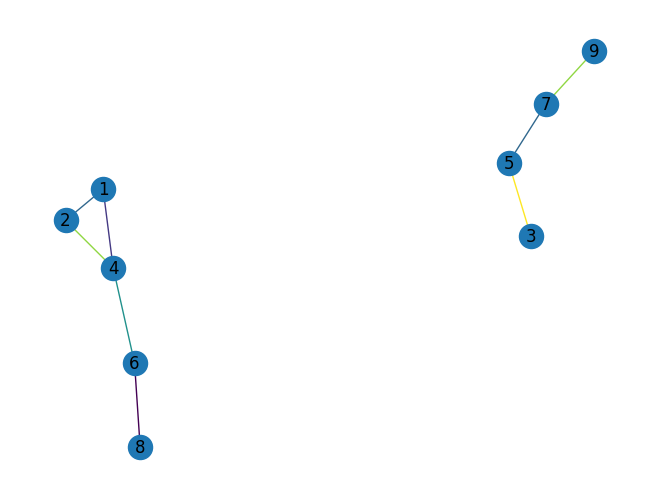

Time taken: 0.052664756774902344 seconds

Running test graph_9_edges.txt...
Minimum edge coloring found.
[3, 5, 1, 2, 2, 6, 3, 7, 4]
Number of colors: 7
Number of iterations: 26


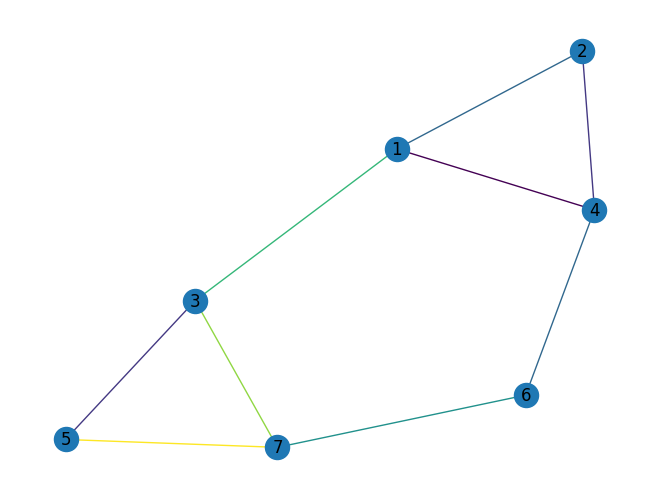

Time taken: 0.06190180778503418 seconds

Running test graph_9_edges_2.txt...
Minimum edge coloring found.
[8, 5, 1, 6, 2, 3, 2, 8, 5]
Number of colors: 6
Number of iterations: 16


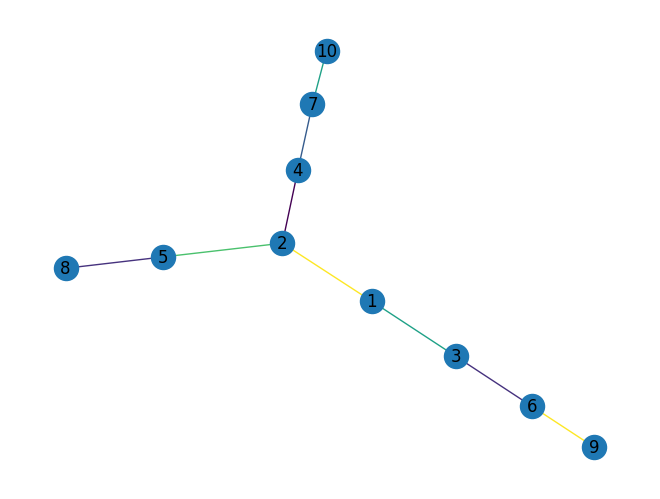

Time taken: 0.0489957332611084 seconds

Running test graph_10_edges.txt...
Minimum edge coloring found.
[2, 3, 8, 4, 8, 4, 7, 4, 8, 6]
Number of colors: 6
Number of iterations: 1


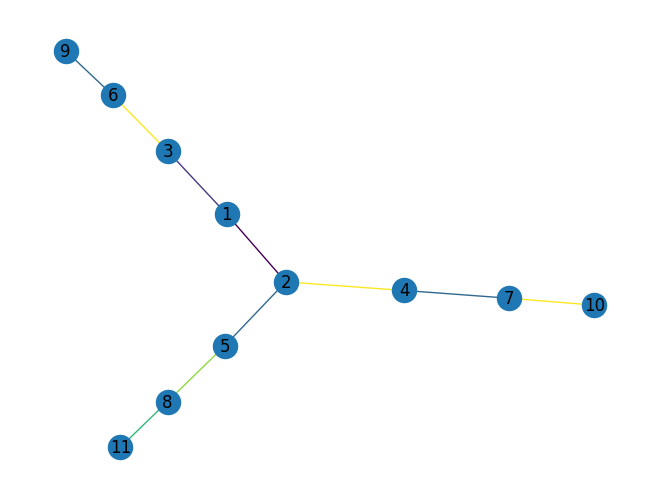

Time taken: 0.08153319358825684 seconds

Running test graph_10_edges_2.txt...
Minimum edge coloring found.
[4, 3, 9, 5, 6, 2, 1, 1, 9, 7]
Number of colors: 8
Number of iterations: 132


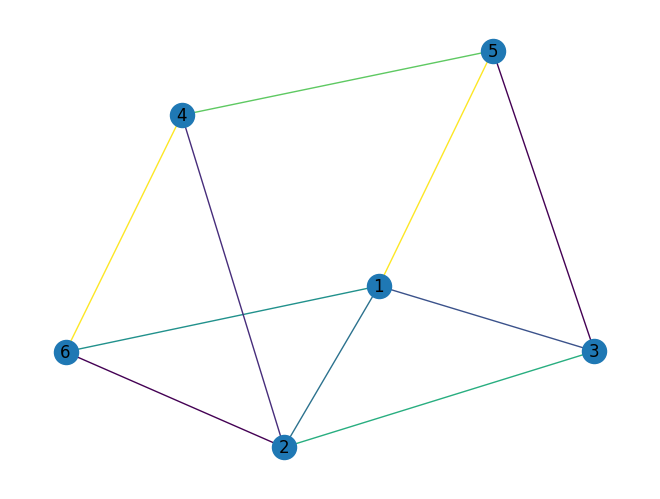

Time taken: 0.06676888465881348 seconds

Running test graph_10_edges_3.txt...
Minimum edge coloring found.
[4, 1, 5, 3, 3, 2, 4, 1, 5, 2]
Number of colors: 5
Number of iterations: 10


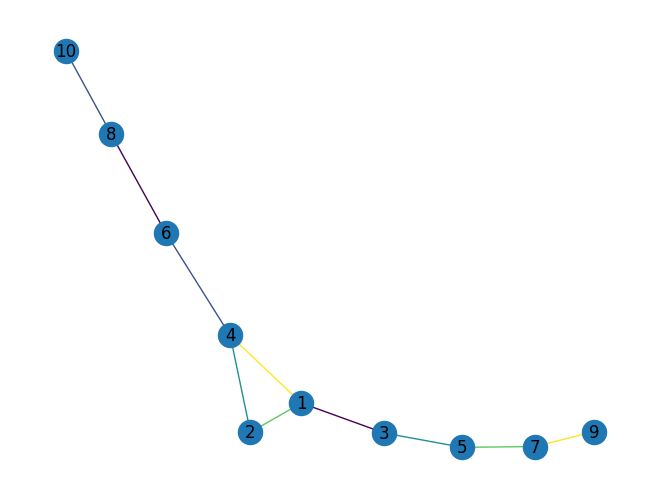

Time taken: 0.06392288208007812 seconds

Running test graph_11_edges.txt...
Minimum edge coloring found.
[9, 5, 3, 2, 4, 1, 8, 6, 3, 6, 2]
Number of colors: 8
Number of iterations: 21


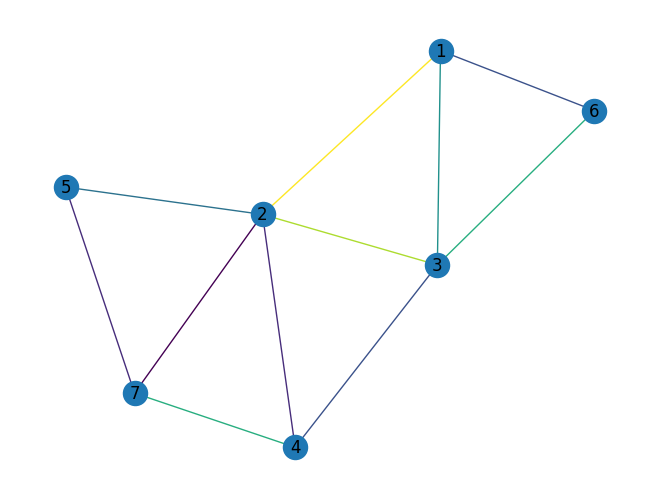

Time taken: 0.08343911170959473 seconds

Running test graph_11_edges_2s.txt...
Minimum edge coloring found.
[3, 2, 6, 7, 8, 6, 4, 8, 9, 3, 7]
Number of colors: 7
Number of iterations: 30


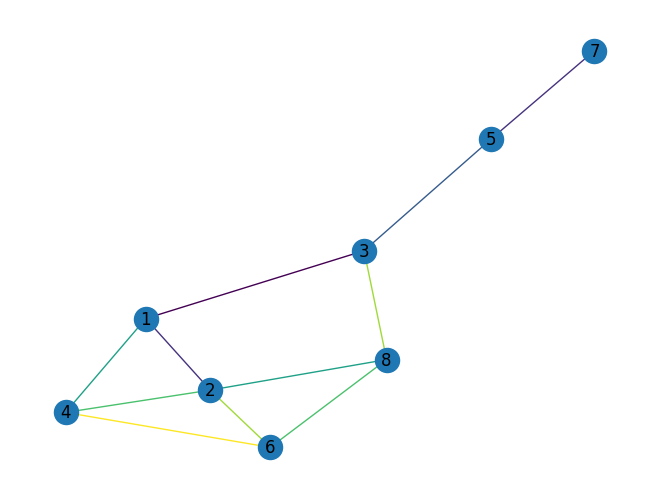

Time taken: 0.07125139236450195 seconds

Running test graph_11_edges_3.txt...
Minimum edge coloring found.
[8, 7, 4, 5, 9, 9, 3, 8, 4, 6, 6]
Number of colors: 7
Number of iterations: 12


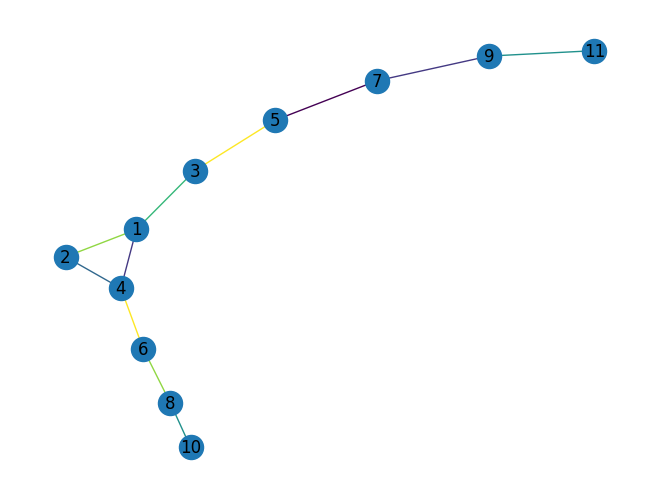

Time taken: 0.09369778633117676 seconds

Running test graph_11_edges_4.txt...
Minimum edge coloring found.
[10, 4, 4, 1, 5, 1, 7, 6, 2, 2, 4]
Number of colors: 7
Number of iterations: 9


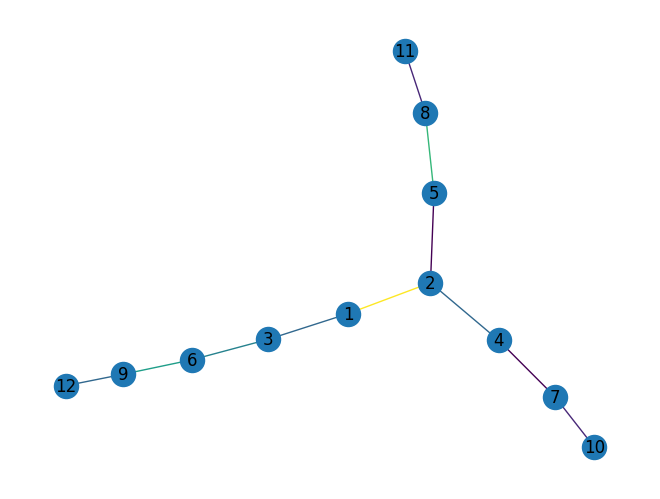

Time taken: 0.08457708358764648 seconds

Running test graph_12_edges.txt...
Minimum edge coloring found.
[10, 3, 6, 5, 7, 9, 5, 5, 7, 8, 9, 9]
Number of colors: 7
Number of iterations: 5


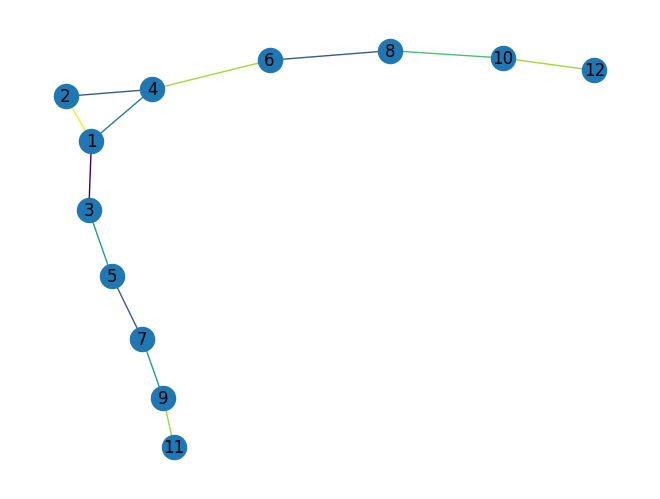

Time taken: 0.06646323204040527 seconds

Running test graph_12_edges_2.txt...
Minimum edge coloring found.
[10, 9, 11, 3, 7, 6, 9, 1, 1, 11, 4, 9]
Number of colors: 8
Number of iterations: 28


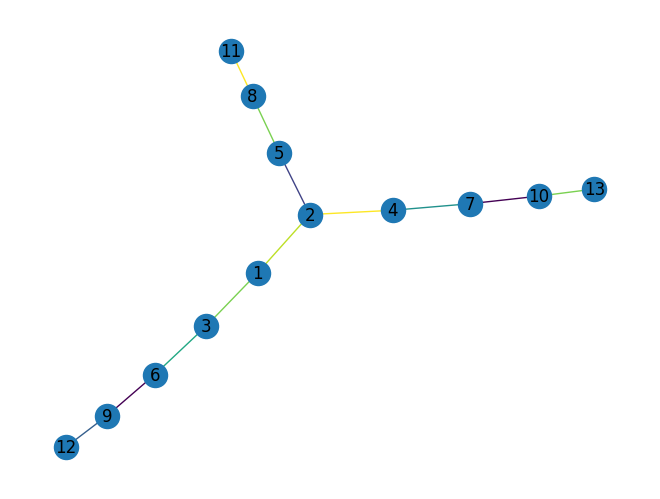

Time taken: 0.06684613227844238 seconds

Running test graph_15_edges.txt...
Minimum edge coloring found.
[1, 9, 5, 2, 13, 8, 7, 6, 2, 7, 3, 1, 9, 13, 11]
Number of colors: 10
Number of iterations: 35


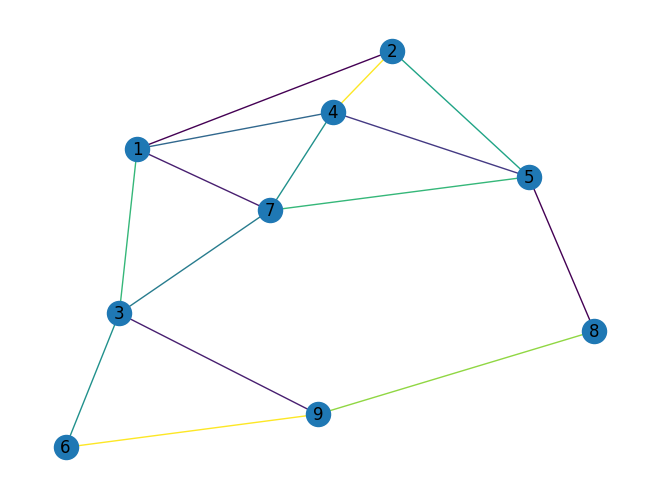

Time taken: 0.08517622947692871 seconds



In [156]:
run_tests('./tests')